# System Dynamics & Project Management?!

## Importing What We Need 

In [217]:
from BPTK_Py import bptk

In [218]:
from BPTK_Py import Model

In [219]:
from BPTK_Py import sd_functions as sd

In [220]:
bptk = bptk() 

## Initializing our Model 

In [221]:
model = Model(starttime=0.0, stoptime=120.0, dt=1.0, name='DSLSimpleProjectManagement')

## Creating Stocks 

In [242]:
openTasks = model.stock("openTasks")
closedTasks = model.stock("closedTasks")
staff = model.stock("staff") #note this stays constant in this model 

## Creating Flows 

In [223]:
completionRate = model.flow("completionRate")

## Creating Converters

In [224]:
currentTime = model.converter("currentTime")
remainingTime = model.converter("remainingTime")
schedulePressure = model.converter("schedulePressure")
productivity = model.converter("productivity")

## Constants

In [225]:
deadline = model.constant("deadline")
effortPerTask = model.constant("effortPerTask")
initialStaff = model.constant("initialStaff")
initialOpenTasks = model.constant("initialOpenTasks")

In [226]:
deadline.equation = 1000.0 #days???
effortPerTask.equation = 1.0
initialStaff.equation = 1.0
initialOpenTasks.equation = 100.0

## Stock Initial Values

In [227]:
closedTasks.initial_value = 0.0
staff.initial_value = initialStaff
openTasks.initial_value = initialOpenTasks

## Creating a Productivity Look Up Table

In [241]:
model.points["productivity"] = [
    [0,0.4],
    [0.25,0.444],
    [0.5,0.506],
    [0.75,0.594],
    [1,1],
    [1.25,1.119],
    [1.5,1.1625],
    [1.75,1.2125],
    [2,1.2375],
    [2.25,1.245],
    [2.5,1.25]
]

##### Creating a non-linear relationship between schedule pressure and productivity

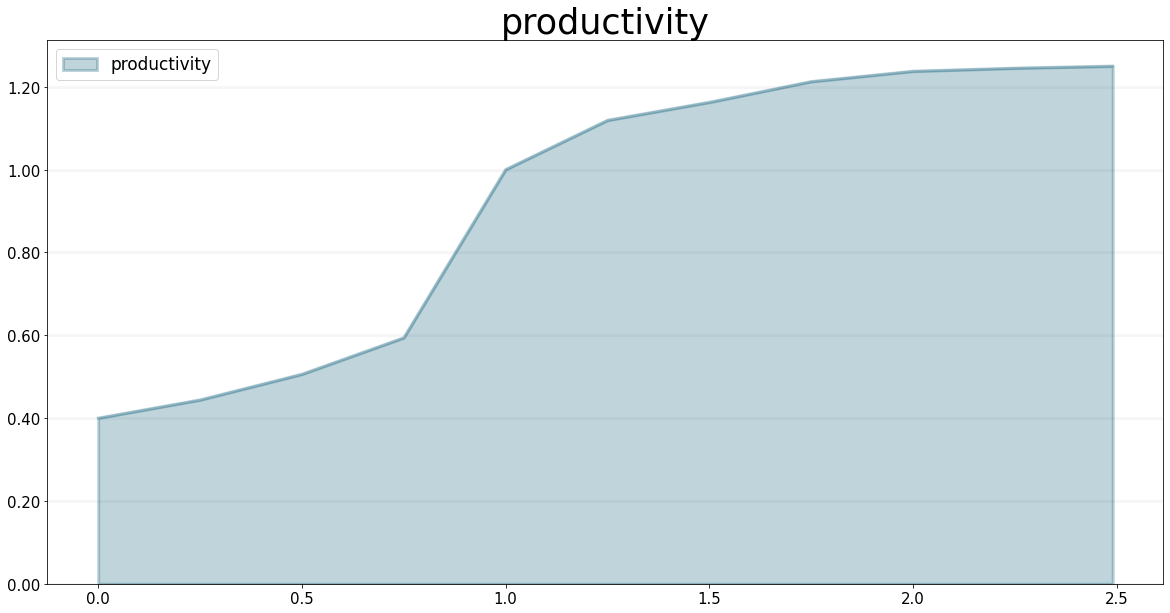

In [240]:
model.plot_lookup("productivity")

## Equations

### Equation for our ***Flow***

\begin{equation*}
Completion Rate  = p * \frac{s} {e}
\end{equation*}

**p** = average productivity of staff
**e** = effort per task,  
**s** = staff

Notes: As the staff grows, so does the completion rate. As the productivity increases so does the completion rate. As the effort per task grows, the completrion rate shrinks. ***sd.min() used to constrain the completion rate to never be larger than the number of open tasks.***

In [234]:
completionRate.equation = sd.max(0.0, sd.min(openTasks, staff*(productivity/effortPerTask)))

### Equations for our ***Converters***

In [228]:
currentTime.equation = sd.time()

In [229]:
remainingTime.equation = deadline - currentTime

In [233]:
productivity.equation = sd.lookup(schedulePressure, "productivity")

\begin{equation*}
Schedule Pressure   = \frac{remaining open tasks} {remaining work capacity} = \frac{(t * e)} {(s * rt)}
\end{equation*}

**t** = open tasks, 
**e** = effort per task,  
**s** = staff, 
**rt** = remaining time 

Notes: Schedule pressure increases when there are more open tasks and higher effort per task. It shrinks when there is a larger staff and there is a larger remaining time. ***sd.max used to ensure division by 0 never occurs. sd.min used to cap the schedule pressure to a max of 2.5***

In [232]:
schedulePressure.equation = sd.min((openTasks * effortPerTask) / (staff * sd.max(remainingTime,1)), 2.5)

### Equations for our ***Stocks*** 

In [230]:
openTasks.equation = -completionRate

In [231]:
closedTasks.equation = completionRate

## Registering Model 

In [236]:
bptk.register_model(model)

## Testing the Model 

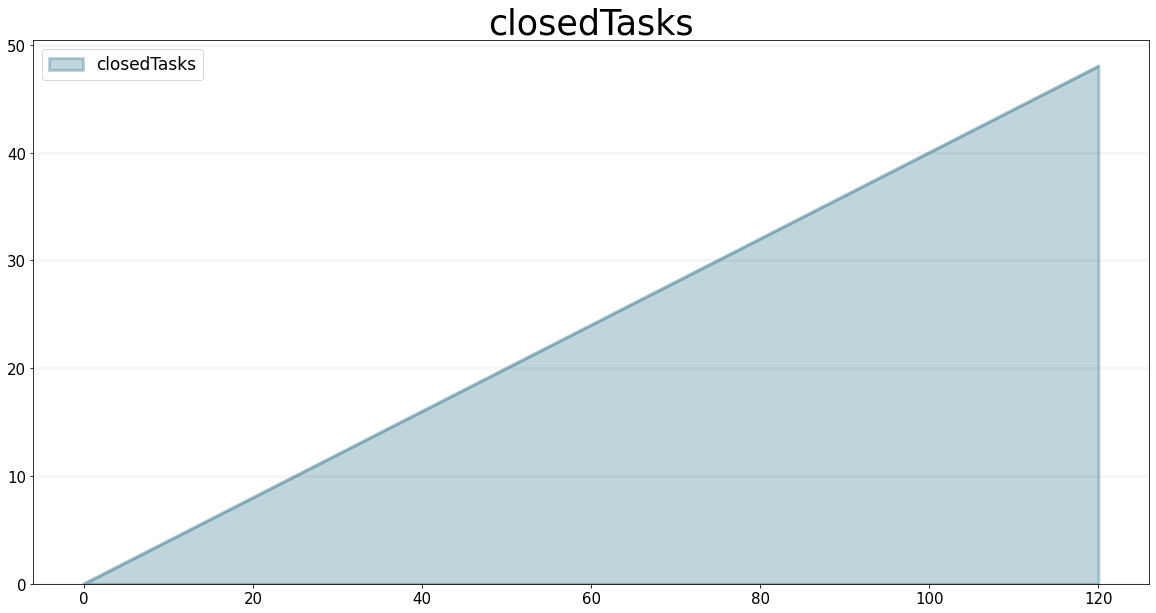

In [262]:
deadline.equation = 100000.0
closedTasks.plot()

In [258]:
closedTasks(120)

100.0